# Image Assembly Guide

Converting raw scanimage-tiff files into fused z-planes.

## TLDR

All you need is a path to your .tiffs and a place to save them.

``` {code-cell} python3
import mbo_utilities as mbo
scan = mbo.read_scan("path/to/data/*.tiff")
mbo.save_as(scan, "path/to/assembled_data", ext=".tiff")
```

In [ ]:
from pathlib import Path
import numpy as np

import fastplotlib as fpl
import mbo_utilities as mbo

## Input data: Path to your raw .tiff file(s)


```{important}

Make sure your `data_path` contains only `.tiff` files for this imaging session. If there are other `.tiff` files, such as from another session or a processed file for this session, those files will be included in the scan and lead to errors.

```

## Initialize a scanreader object

Pass a list of files, or a wildcard "/path/to/files/*" to `mbo.read_scan()`.

``` {tip}
mbo.get_files() is useful to easily get all files of the same filetype
```

In [8]:
files = mbo.get_files("/home/flynn/lbm_data/mk301", 'tif')
files[:2]

['/home/flynn/lbm_data/mk301/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00004.tif',
 '/home/flynn/lbm_data/mk301/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif']

In [9]:
scan = mbo.read_scan(files)

# T, Z, X, Y
scan.shape

(1437, 14, 448, 448)

In [10]:
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'frame-rate: {scan.fps}')

Planes: 14
Frames: 1437
ROIs: 2
frame-rate: 17.06701142272251


## Accessing data in the scan

The scan can be indexed like a numpy array, data will be loaded lazily as only the data you access here is loaded in memory.

```{admonition} A note on performance
:class: dropdown

When you initialize a scan with `read_scan`, [tifffile](https://github.com/cgohlke/tifffile/blob/master/tifffile/tifffile.py) is going to iterate through every page in your tiff to "count" how many pages there are.
. Only a single page of data is held in memory, and using that information we can lazily load the scan (this is what the scanreader does).

For a single 35 Gb file, this process takes ~10 seconds.
For 216 files totaling 231 GB, ~ 2 minutes.

This only occurs once, and is cached by your operating system. So the next time you read the same scan, a 35GB file will be nearly instant, and a series of 216 files ~8 seconds.

```

In [13]:
# load the first 6 frames (0 to 5), the first z-plane, and all X/Y pixels
array = scan[:5, 0, :, :]
print(f'[T, X, Y]: {array.shape}')

# load a z stack, with a single frame for each Z
array = scan[0, :, :, :]
# 4 fields (join_contiguous=False), one for each ROI
print(f'[Z, X, Y]: {array.shape}')

[T, X, Y]: (5, 448, 448)
[Z, X, Y]: (14, 448, 448)


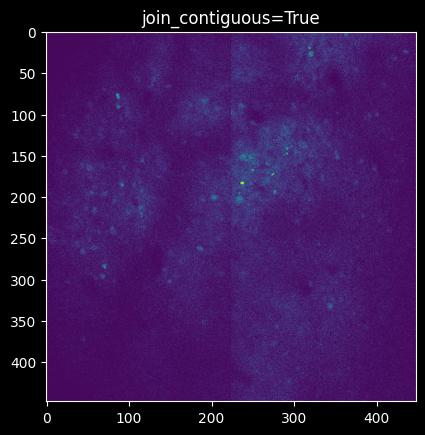

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(scan[0, 6, :, :])
plt.title('join_contiguous=True')
plt.show()


This will display a widget allowing you to scroll in time and in z.

In [ ]:
image_widget = mbo.run_gui(scan)
image_widget.show()

In [17]:
image_widget.close()

## Save assembled files

The currently supported file extensions are `.tiff`.

In [20]:
save_path = Path("/home/flynn/lbm_data/mk301/assembled")
save_path.mkdir(exist_ok=True)

mbo.save_as(
    scan,
    save_path,
    planes=[0, 6, 13],      # for 14 z-planes, first, middle, last 
    overwrite=True,
    ext = '.tiff',
    trim_edge=[2, 2, 2, 2], # post-assembly pixels to trim [left, right, top, bottom]
    append_str="_demo",      # this will be appended to the filename, 'plane_N_demo.ext'
    fix_phase=False          # fix bi-directional scan phase offset
)

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.
Saving 1437x14x448x448 in /home/flynn/lbm_data/mk301/assembled
[2, 2, 2, 2]
New height: 444
New width: 444


Saving plane 1:   0%|          | 0/56 [00:00<?, ?it/s]

Saving plane 7:   0%|          | 0/56 [00:00<?, ?it/s]

Saving plane 14:   0%|          | 0/56 [00:00<?, ?it/s]

Time elapsed: 0 minutes 5 seconds.


## Vizualize data with [fastplotlib](https://www.fastplotlib.org/user_guide/guide.html#what-is-fastplotlib)

To get a rough idea of the quality of your extracted timeseries, we can create a fastplotlib visualization to preview traces of individual pixels.

Here, we simply click on any pixel in the movie, and we get a 2D trace (or "temporal component" as used in this field) of the pixel through the course of the movie.

More advanced visualizations can be easily created, i.e. adding a baseline subtracted element to the trace, or passing the trace through a frequency filter.

In [ ]:
import tifffile
from ipywidgets import VBox

img = tifffile.memmap("/home/flynn/lbm_data/mk301/assembled/plane_07_demo.tiff")
iw_movie = fpl.ImageWidget(img, cmap="viridis")

tfig = fpl.Figure()

raw_trace = tfig[0, 0].add_line(np.zeros(img.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] =  iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

VBox([iw_movie.show(), tfig.show()])


```{image} ../_images/raw_preview.png
:alt: Preview widget
:width: 500px
:align: center
```